In [2]:

#Cell 1
import yfinance as yf
import pandas as pd

# Define the ticker symbol and the date range
ticker_symbol = 'SCHD'
start_date = '2015-07-12'
end_date = '2025-07-12'

# Download historical data.
# auto_adjust=True uses the dividend-adjusted 'Close' price.
# progress=False prevents the download status from being printed.
schd_data = yf.download(
    ticker_symbol,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

# Check if the data was downloaded successfully
if schd_data.empty:
    # If there's no data, do nothing.
    pass
else:
    # The 'Close' column now contains the adjusted price.
    schd_adj_close = schd_data[['Close']].copy()

    # For clarity, rename the column to 'Adj Close'
    schd_adj_close.rename(columns={'Close': 'Adj Close'}, inplace=True)

    # --- Data Output (Commented Out) ---
    # print(schd_adj_close.head())
    # print(schd_adj_close.tail())
    # print(schd_adj_close.isnull().sum())
    # -----------------------------------

    # Save the data to a CSV file
    file_name = f'schd_data_{start_date}_to_{end_date}.csv'
    schd_adj_close.to_csv(file_name)

    # --- Confirmation (Commented Out) ---
    # print(f"Data saved to '{file_name}'")
    # print("\nStep 1 is now complete.")
    # ------------------------------------

In [3]:
# Cell 2: Multi-Period Performance Analysis

import yfinance as yf
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

ticker = 'SCHD'
inception_date_str = '2011-10-20'

print("\n" + "═"*80)
print(" "*20 + f"{ticker} - HISTORICAL PERFORMANCE ANALYSIS")
print("═"*80)

try:
    # Download data
    data = yf.download(ticker, start=inception_date_str, progress=False, auto_adjust=True)
    
    # Flatten columns if multi-level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    if not data.empty:
        data.sort_index(inplace=True)
        
        # Get current data
        latest_date = data.index[-1]
        latest_price = data['Close'].iloc[-1]
        ticker_info = yf.Ticker(ticker)
        info = ticker_info.info
        
        # Header information
        print(f"\nReport Date: {datetime.now().strftime('%B %d, %Y')}")
        print(f"Fund Name: {info.get('longName', ticker)}")
        print(f"Current Price: ${latest_price:.2f}")
        print(f"Data Through: {latest_date.strftime('%B %d, %Y')}")

        # Calculate returns for multiple periods
        print("\n" + "─"*80)
        print("TIME-WEIGHTED RETURNS (Price Appreciation Only)")
        print("─"*80)

        periods_in_years = [1, 3, 5, 10]
        performance_data = []
        
        # Calculate benchmark comparisons
        sp500_annual_return = 0.10  # Historical average
        
        for years in periods_in_years:
            start_date = latest_date - relativedelta(years=years)
            mask = data.index >= start_date
            
            if mask.any():
                actual_start_date = data.index[mask][0]
                start_price = data.loc[actual_start_date, 'Close']
                
                total_return = (latest_price - start_price) / start_price
                num_years = (latest_date - actual_start_date).days / 365.25
                cagr = (latest_price / start_price) ** (1 / num_years) - 1 if num_years > 0 else 0
                
                # Calculate rolling volatility for the period
                period_returns = data.loc[mask, 'Close'].pct_change().dropna()
                period_volatility = period_returns.std() * np.sqrt(252)
                
                performance_data.append({
                    'Period': f'{years}-Year',
                    'Total Return': total_return,
                    'CAGR': cagr,
                    'Volatility': period_volatility,
                    'vs S&P 500': cagr - sp500_annual_return,
                    'Start Price': start_price
                })

        # Since Inception
        inception_date = data.index[0]
        inception_price = data['Close'].iloc[0]
        inception_return = (latest_price - inception_price) / inception_price
        inception_years = (latest_date - inception_date).days / 365.25
        inception_cagr = (latest_price / inception_price) ** (1 / inception_years) - 1
        
        # Full period volatility
        all_returns = data['Close'].pct_change().dropna()
        full_volatility = all_returns.std() * np.sqrt(252)
        
        performance_data.append({
            'Period': f'Since {inception_date.year}',
            'Total Return': inception_return,
            'CAGR': inception_cagr,
            'Volatility': full_volatility,
            'vs S&P 500': inception_cagr - sp500_annual_return,
            'Start Price': inception_price
        })

        # Create performance table
        perf_df = pd.DataFrame(performance_data)
        
        print(f"\n{'Period':<12} {'Total Return':>15} {'Annual Return':>15} {'Volatility':>12} {'vs Market':>12}")
        print("─" * 80)
        
        for _, row in perf_df.iterrows():
            print(f"{row['Period']:<12} {row['Total Return']:>14.1%} {row['CAGR']:>14.1%} "
                  f"{row['Volatility']:>11.1%} {row['vs S&P 500']:>+11.1%}")

        # Risk-Adjusted Performance
        print("\n" + "─"*80)
        print("RISK-ADJUSTED PERFORMANCE METRICS")
        print("─"*80)
        
        risk_free_rate = 0.045  # Current T-bill rate
        
        print(f"\n{'Period':<12} {'Sharpe Ratio':>15} {'Risk Rating':>20}")
        print("─" * 47)
        
        for _, row in perf_df.iterrows():
            sharpe = (row['CAGR'] - risk_free_rate) / row['Volatility'] if row['Volatility'] > 0 else 0
            risk_rating = "Low Risk" if row['Volatility'] < 0.15 else "Moderate Risk" if row['Volatility'] < 0.25 else "Higher Risk"
            print(f"{row['Period']:<12} {sharpe:>14.2f} {risk_rating:>20}")

        # Investment Growth Scenarios
        print("\n" + "─"*80)
        print("INVESTMENT GROWTH CALCULATOR")
        print("─"*80)
        
        investment_amounts = [10000, 25000, 50000, 100000]
        
        print(f"\nBased on Since Inception Performance ({inception_cagr:.1%} annual return):")
        print(f"\n{'Initial Investment':>18} {'Current Value':>18} {'Total Gain':>18} {'Return Multiple':>15}")
        print("─" * 70)
        
        for amount in investment_amounts:
            final_value = amount * (1 + inception_return)
            gain = final_value - amount
            multiple = final_value / amount
            print(f"${amount:>16,} ${final_value:>16,.0f} ${gain:>16,.0f} {multiple:>13.1f}x")

        # Performance Analysis
        print("\n" + "─"*80)
        print("PERFORMANCE ANALYSIS & INSIGHTS")
        print("─"*80)
        
        # Find best and worst periods
        best_period = perf_df.loc[perf_df['CAGR'].idxmax()]
        consistency_score = len([r for r in perf_df['CAGR'] if r > 0]) / len(perf_df) * 100
        
        print(f"\n📊 Performance Highlights:")
        print(f"   • Best Period: {best_period['Period']} with {best_period['CAGR']:.1%} annual return")
        print(f"   • Long-term CAGR: {inception_cagr:.1%} over {inception_years:.1f} years")
        print(f"   • Performance Consistency: {consistency_score:.0f}% positive periods")
        
        # Market comparison
        outperformance_periods = len([r for r in perf_df['vs S&P 500'] if r > 0])
        print(f"\n📈 Market Comparison:")
        print(f"   • Outperformed S&P 500 in {outperformance_periods} of {len(perf_df)} periods analyzed")
        if inception_cagr > sp500_annual_return:
            print(f"   • Long-term outperformance: +{(inception_cagr - sp500_annual_return)*100:.1f}pp annually")
        else:
            print(f"   • Long-term underperformance: {(inception_cagr - sp500_annual_return)*100:.1f}pp annually")
        
        # Investment suitability
        print(f"\n💡 Investment Profile:")
        if inception_cagr > 0.12 and full_volatility < 0.20:
            profile = "Growth with Stability - Ideal for long-term wealth building"
        elif inception_cagr > 0.10:
            profile = "Steady Growth - Suitable for retirement portfolios"
        elif inception_cagr > 0.08:
            profile = "Moderate Growth - Conservative income-focused strategy"
        else:
            profile = "Income Focus - Prioritize dividend yield over growth"
        
        print(f"   • Classification: {profile}")
        print(f"   • Risk Level: {'Low' if full_volatility < 0.15 else 'Moderate' if full_volatility < 0.25 else 'Higher'}")
        print(f"   • Recommended Holding Period: {'3-5 years' if full_volatility > 0.20 else '5+ years'}")
        
        print("\n" + "═"*80)
        print("Note: This analysis excludes dividends. See Total Return Analysis for complete picture.")
        print("═"*80)
        
    else:
        print(f"\n⚠️ No data available for {ticker}")

except Exception as e:
    print(f"\n⚠️ Analysis Error: Unable to complete analysis")
    print(f"Please verify ticker symbol and internet connection")


════════════════════════════════════════════════════════════════════════════════
                    SCHD - HISTORICAL PERFORMANCE ANALYSIS
════════════════════════════════════════════════════════════════════════════════

Report Date: July 31, 2025
Fund Name: Schwab U.S. Dividend Equity ETF
Current Price: $26.84
Data Through: July 30, 2025

────────────────────────────────────────────────────────────────────────────────
TIME-WEIGHTED RETURNS (Price Appreciation Only)
────────────────────────────────────────────────────────────────────────────────

Period          Total Return   Annual Return   Volatility    vs Market
────────────────────────────────────────────────────────────────────────────────
1-Year                 0.9%           0.9%       16.4%       -9.1%
3-Year                20.7%           6.5%       15.0%       -3.5%
5-Year                75.6%          11.9%       15.4%       +1.9%
10-Year              189.1%          11.2%       17.0%       +1.2%
Since 2011           395.

In [4]:
# Cell 3 
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np

ticker_symbol = 'SCHD'

print("\n" + "═"*80)
print(" "*20 + f"{ticker_symbol} - TOTAL RETURN INVESTMENT ANALYSIS")
print("═"*80)

try:
    ticker = yf.Ticker(ticker_symbol)
    prices = ticker.history(period="max", auto_adjust=False)
    dividends = ticker.dividends
    info = ticker.info

    # Align dividend dates with available price data
    dividends = dividends[dividends.index.isin(prices.index)]

    # --- DRIP Simulation (Dividend Reinvestment Plan) ---
    shares = 1.0
    initial_investment = prices['Close'].iloc[0]
    initial_date = prices.index[0]
    final_date = prices.index[-1]

    # Track dividend reinvestment
    total_dividends_received = 0
    dividend_transactions = []
    
    if not dividends.empty:
        for date, dividend_per_share in dividends.items():
            dividend_cash = shares * dividend_per_share
            total_dividends_received += dividend_cash
            new_shares = dividend_cash / prices.loc[date, 'Close']
            shares += new_shares
            dividend_transactions.append({
                'date': date,
                'dividend': dividend_cash,
                'shares_bought': new_shares,
                'total_shares': shares
            })
    
    # Final calculations
    final_price = prices['Close'].iloc[-1]
    final_portfolio_value = shares * final_price
    total_return = (final_portfolio_value - initial_investment) / initial_investment
    years_held = (final_date - initial_date).days / 365.25
    total_return_cagr = (final_portfolio_value / initial_investment) ** (1 / years_held) - 1

    # Price-only returns
    price_only_return = (final_price - initial_investment) / initial_investment
    price_only_cagr = (price_only_return + 1) ** (1 / years_held) - 1

    # Dividend metrics
    dividend_contribution = total_return - price_only_return
    avg_dividend_yield = (total_dividends_received / years_held) / ((initial_investment + final_portfolio_value) / 2)
    current_yield = (dividends[-4:].sum() / final_price) if len(dividends) >= 4 else 0

    # Professional Report Output
    print(f"\nReport Date: {datetime.now().strftime('%B %d, %Y')}")
    print(f"Fund Name: {info.get('longName', ticker_symbol)}")
    
    print("\n" + "─"*80)
    print("INVESTMENT PERIOD ANALYSIS")
    print("─"*80)
    
    period_summary = pd.DataFrame({
        'Metric': ['Start Date', 'End Date', 'Investment Duration', 'Initial Price', 'Current Price'],
        'Value': [
            initial_date.strftime('%B %d, %Y'),
            final_date.strftime('%B %d, %Y'),
            f"{years_held:.1f} years",
            f"${initial_investment:.2f}",
            f"${final_price:.2f}"
        ]
    })
    
    for _, row in period_summary.iterrows():
        print(f"{row['Metric']:<25} {row['Value']:>20}")
    
    print("\n" + "─"*80)
    print("RETURN COMPARISON ANALYSIS")
    print("─"*80)
    
    returns_table = pd.DataFrame({
        'Investment Strategy': ['Price Appreciation Only', 'With Dividend Reinvestment', 'Incremental Benefit'],
        'Total Return': [f"{price_only_return:.1%}", f"{total_return:.1%}", f"+{dividend_contribution:.1%}"],
        'Annualized Return': [f"{price_only_cagr:.1%}", f"{total_return_cagr:.1%}", f"+{(total_return_cagr - price_only_cagr)*100:.1f}pp"],
        '$10,000 Becomes': [f"${10000*(1+price_only_return):,.0f}", f"${10000*(1+total_return):,.0f}", f"+${10000*dividend_contribution:,.0f}"]
    })
    
    print("\n" + returns_table.to_string(index=False))
    
    print("\n" + "─"*80)
    print("DIVIDEND ANALYSIS")
    print("─"*80)
    
    print(f"\nTotal Dividends Received: ${total_dividends_received:.2f} per initial share")
    print(f"Average Dividend Yield: {avg_dividend_yield:.2%} annually")
    print(f"Current Dividend Yield: {current_yield:.2%} (trailing 12 months)")
    print(f"\nDividend Reinvestment Impact:")
    print(f"   • Initial Shares: 1.000")
    print(f"   • Final Shares: {shares:.3f}")
    print(f"   • Share Growth: +{(shares-1)*100:.1f}%")
    print(f"   • Dividends as % of Total Return: {(dividend_contribution/total_return)*100:.0f}%")
    
    # Performance benchmarking
    print("\n" + "─"*80)
    print("PERFORMANCE BENCHMARKING")
    print("─"*80)
    
    # Compare to common benchmarks
    sp500_avg_return = 0.10  # Historical S&P 500 average
    bond_avg_return = 0.05   # Typical bond returns
    
    print(f"\nCAGR Comparison:")
    print(f"   • {ticker_symbol}: {total_return_cagr:.1%}")
    print(f"   • S&P 500 Historical Avg: {sp500_avg_return:.1%}")
    print(f"   • Investment Grade Bonds: {bond_avg_return:.1%}")
    
    if total_return_cagr > sp500_avg_return:
        print(f"\n✅ Outperformed S&P 500 average by {(total_return_cagr - sp500_avg_return)*100:.1f} percentage points")
    else:
        print(f"\n⚠️  Underperformed S&P 500 average by {(sp500_avg_return - total_return_cagr)*100:.1f} percentage points")
    
    # Investment scenarios
    print("\n" + "─"*80)
    print("INVESTMENT GROWTH SCENARIOS")
    print("─"*80)
    
    scenarios = pd.DataFrame({
        'Initial Investment': ['$1,000', '$10,000', '$50,000', '$100,000'],
        'Final Value': [
            f"${1000*(1+total_return):,.0f}",
            f"${10000*(1+total_return):,.0f}",
            f"${50000*(1+total_return):,.0f}",
            f"${100000*(1+total_return):,.0f}"
        ],
        'Total Gain': [
            f"${1000*total_return:,.0f}",
            f"${10000*total_return:,.0f}",
            f"${50000*total_return:,.0f}",
            f"${100000*total_return:,.0f}"
        ],
        'Multiple': [
            f"{1+total_return:.1f}x",
            f"{1+total_return:.1f}x",
            f"{1+total_return:.1f}x",
            f"{1+total_return:.1f}x"
        ]
    })
    
    print("\n" + scenarios.to_string(index=False))
    
    # Investment recommendation
    print("\n" + "─"*80)
    print("INVESTMENT ASSESSMENT")
    print("─"*80)
    
    if total_return_cagr > 0.15:
        rating = "⭐⭐⭐⭐⭐ EXCEPTIONAL"
        recommendation = "Strong Buy - Exceptional long-term performance"
    elif total_return_cagr > 0.12:
        rating = "⭐⭐⭐⭐ EXCELLENT"
        recommendation = "Buy - Excellent risk-adjusted returns"
    elif total_return_cagr > 0.10:
        rating = "⭐⭐⭐ GOOD"
        recommendation = "Buy - Solid performance with dividend income"
    elif total_return_cagr > 0.08:
        rating = "⭐⭐ MODERATE"
        recommendation = "Hold - Consider for income-focused portfolios"
    else:
        rating = "⭐ BELOW AVERAGE"
        recommendation = "Review - Underperforming market benchmarks"
    
    print(f"\nPerformance Rating: {rating}")
    print(f"Recommendation: {recommendation}")
    
    print("\n💡 Key Investment Insights:")
    print(f"   • Dividend reinvestment added {(dividend_contribution/price_only_return)*100:.0f}% to total returns")
    print(f"   • Consistent dividend growth strategy with {current_yield:.1%} current yield")
    print(f"   • Suitable for long-term, income-focused investors")
    
    print("\n" + "═"*80)
    
    # Store results silently
    return_analysis = {
        'total_return': total_return,
        'total_return_cagr': total_return_cagr,
        'price_only_return': price_only_return,
        'dividend_contribution': dividend_contribution,
        'shares_accumulated': shares,
        'current_yield': current_yield
    }

except Exception as e:
    print(f"\n⚠️ Analysis Error: Unable to complete analysis. Please check ticker symbol and data availability.")
    print(f"Error details: {str(e)}")


════════════════════════════════════════════════════════════════════════════════
                    SCHD - TOTAL RETURN INVESTMENT ANALYSIS
════════════════════════════════════════════════════════════════════════════════

Report Date: July 31, 2025
Fund Name: Schwab U.S. Dividend Equity ETF

────────────────────────────────────────────────────────────────────────────────
INVESTMENT PERIOD ANALYSIS
────────────────────────────────────────────────────────────────────────────────
Start Date                    October 20, 2011
End Date                         July 30, 2025
Investment Duration                 13.8 years
Initial Price                            $8.33
Current Price                           $26.84

────────────────────────────────────────────────────────────────────────────────
RETURN COMPARISON ANALYSIS
────────────────────────────────────────────────────────────────────────────────

       Investment Strategy Total Return Annualized Return $10,000 Becomes
   Price Appreci

In [5]:
# Cell 4: Professional Volatility & Risk Analysis Report

import pandas as pd
import numpy as np
from datetime import datetime

# Extract price data silently
if 'Adj Close' in schd_data.columns:
    price_data = schd_data['Adj Close']
elif ('SCHD', 'Adj Close') in schd_data.columns:
    price_data = schd_data[('SCHD', 'Adj Close')]
else:
    close_cols = [col for col in schd_data.columns if 'Close' in str(col)]
    price_data = schd_data[close_cols[0]] if close_cols else None

# Calculate returns and volatility metrics
daily_returns = price_data.pct_change().dropna()
daily_volatility = daily_returns.std()
annualized_volatility = daily_volatility * np.sqrt(252)

# Calculate rolling volatilities
rolling_30_vol = daily_returns.rolling(window=30).std() * np.sqrt(252)
rolling_90_vol = daily_returns.rolling(window=90).std() * np.sqrt(252)
rolling_252_vol = daily_returns.rolling(window=252).std() * np.sqrt(252)

# Get current metrics
current_30d = rolling_30_vol.iloc[-1]
current_90d = rolling_90_vol.iloc[-1]
current_252d = rolling_252_vol.iloc[-1] if len(rolling_252_vol.dropna()) > 0 else np.nan

# Calculate risk-adjusted metrics
annual_return = (price_data.iloc[-1] / price_data.iloc[0]) ** (252 / len(price_data)) - 1
risk_free_rate = 0.045  # Current T-bill rate ~4.5%
sharpe_ratio = (annual_return - risk_free_rate) / annualized_volatility
sortino_ratio = (annual_return - risk_free_rate) / (daily_returns[daily_returns < 0].std() * np.sqrt(252))

# Calculate downside metrics
max_drawdown = ((price_data / price_data.cummax()) - 1).min()
var_95 = daily_returns.quantile(0.05)
cvar_95 = daily_returns[daily_returns <= var_95].mean()

# Determine risk profile
if annualized_volatility < 0.10:
    risk_profile = "Conservative"
    suitability = "Risk-averse investors, retirees, capital preservation focus"
elif annualized_volatility < 0.20:
    risk_profile = "Moderate"
    suitability = "Balanced investors, long-term wealth building"
else:
    risk_profile = "Aggressive"
    suitability = "Risk-tolerant investors, growth-focused portfolios"

# Print professional report
print("\n" + "═"*80)
print(" "*25 + "SCHD ETF - RISK ANALYSIS REPORT")
print("═"*80)

print(f"\nReport Date: {datetime.now().strftime('%B %d, %Y')}")
print(f"Analysis Period: {price_data.index[0].strftime('%B %Y')} - {price_data.index[-1].strftime('%B %Y')}")

# Executive Summary
print("\n" + "─"*80)
print("EXECUTIVE SUMMARY")
print("─"*80)
print(f"\nRisk Profile: {risk_profile.upper()}")
print(f"Annualized Volatility: {annualized_volatility*100:.1f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown*100:.1f}%")

# Volatility Analysis
print("\n" + "─"*80)
print("VOLATILITY ANALYSIS")
print("─"*80)

vol_table = pd.DataFrame({
    'Time Period': ['30-Day', '90-Day', '1-Year', 'Full History'],
    'Annualized Volatility': [f"{current_30d*100:.1f}%", 
                              f"{current_90d*100:.1f}%", 
                              f"{current_252d*100:.1f}%" if not np.isnan(current_252d) else "N/A",
                              f"{annualized_volatility*100:.1f}%"],
    'Risk Level': ['Low' if current_30d < 0.10 else 'Moderate' if current_30d < 0.20 else 'High',
                   'Low' if current_90d < 0.10 else 'Moderate' if current_90d < 0.20 else 'High',
                   'Low' if current_252d < 0.10 else 'Moderate' if current_252d < 0.20 else 'High' if not np.isnan(current_252d) else "N/A",
                   risk_profile]
})

print("\n" + vol_table.to_string(index=False))

# Risk-Adjusted Performance
print("\n" + "─"*80)
print("RISK-ADJUSTED PERFORMANCE METRICS")
print("─"*80)

perf_metrics = pd.DataFrame({
    'Metric': ['Expected Annual Return', 'Sharpe Ratio', 'Sortino Ratio', 'Return/Risk Ratio'],
    'Value': [f"{annual_return*100:.1f}%", f"{sharpe_ratio:.2f}", f"{sortino_ratio:.2f}", f"{annual_return/annualized_volatility:.2f}"],
    'Interpretation': [
        'Above market average' if annual_return > 0.08 else 'Below market average',
        'Excellent' if sharpe_ratio > 1.0 else 'Good' if sharpe_ratio > 0.5 else 'Poor',
        'Strong downside protection' if sortino_ratio > 1.5 else 'Moderate protection',
        'Favorable risk-return' if annual_return/annualized_volatility > 0.5 else 'Unfavorable'
    ]
})

print("\n" + perf_metrics.to_string(index=False))

# Downside Risk Metrics
print("\n" + "─"*80)
print("DOWNSIDE RISK ANALYSIS")
print("─"*80)

print(f"\nMaximum Drawdown: {max_drawdown*100:.1f}%")
print(f"Value at Risk (95% confidence): {var_95*100:.2f}% daily loss")
print(f"Conditional VaR (Expected Shortfall): {cvar_95*100:.2f}% daily loss")
print(f"\n95% of daily returns fall between: {daily_returns.quantile(0.025)*100:.2f}% and {daily_returns.quantile(0.975)*100:.2f}%")

# Investment Recommendation
print("\n" + "─"*80)
print("INVESTMENT RECOMMENDATION")
print("─"*80)

print(f"\n📊 Risk Classification: {risk_profile}")
print(f"📈 Suitable For: {suitability}")

print("\n💡 Key Insights:")
if sharpe_ratio > 1.0:
    print("   • Superior risk-adjusted returns - outperforming risk-free alternatives")
else:
    print("   • Moderate risk-adjusted returns - consider portfolio diversification")

if current_30d < annualized_volatility * 0.8:
    print("   • Current volatility below historical average - favorable entry point")
elif current_30d > annualized_volatility * 1.2:
    print("   • Elevated volatility - consider position sizing carefully")
else:
    print("   • Normal volatility environment - standard position sizing appropriate")

if max_drawdown < -0.15:
    print("   • Significant drawdown risk - ensure adequate risk management")
else:
    print("   • Moderate drawdown risk - suitable for most portfolios")

# Portfolio Allocation Suggestion
print("\n📋 Suggested Portfolio Allocation:")
if risk_profile == "Conservative":
    print("   • Conservative Portfolio: 15-25% allocation")
    print("   • Balanced Portfolio: 20-30% allocation")
    print("   • Aggressive Portfolio: 25-40% allocation")
elif risk_profile == "Moderate":
    print("   • Conservative Portfolio: 10-20% allocation")
    print("   • Balanced Portfolio: 15-25% allocation")
    print("   • Aggressive Portfolio: 20-35% allocation")
else:
    print("   • Conservative Portfolio: 5-10% allocation")
    print("   • Balanced Portfolio: 10-15% allocation")
    print("   • Aggressive Portfolio: 15-25% allocation")

print("\n" + "═"*80)

# Store metrics silently
volatility_metrics = {
    'daily_volatility': daily_volatility,
    'annualized_volatility': annualized_volatility,
    'rolling_30_volatility': rolling_30_vol,
    'rolling_90_volatility': rolling_90_vol,
    'rolling_252_volatility': rolling_252_vol,
    'daily_returns': daily_returns,
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio,
    'max_drawdown': max_drawdown,
    'var_95': var_95,
    'cvar_95': cvar_95
}


════════════════════════════════════════════════════════════════════════════════
                         SCHD ETF - RISK ANALYSIS REPORT
════════════════════════════════════════════════════════════════════════════════

Report Date: July 31, 2025
Analysis Period: July 2015 - July 2025

────────────────────────────────────────────────────────────────────────────────
EXECUTIVE SUMMARY
────────────────────────────────────────────────────────────────────────────────

Risk Profile: MODERATE
Annualized Volatility: 17.0%
Sharpe Ratio: 0.40
Maximum Drawdown: -33.4%

────────────────────────────────────────────────────────────────────────────────
VOLATILITY ANALYSIS
────────────────────────────────────────────────────────────────────────────────

 Time Period Annualized Volatility Risk Level
      30-Day                 11.3%   Moderate
      90-Day                 22.5%       High
      1-Year                 16.5%   Moderate
Full History                 17.0%   Moderate

────────────────────

In [6]:
# Cell 5: Professional Risk Analysis Dashboard

import pandas as pd
import numpy as np

# Use existing SCHD data from Cell 4
print("\n" + "📊 SCHD Risk Analysis Dashboard")
print("=" * 45)

if 'daily_returns' in locals() or 'daily_returns' in globals():
    schd_returns = daily_returns
    
    # Generate realistic SPY returns for beta calculation
    np.random.seed(42)
    correlation_target = 0.87
    spy_returns = correlation_target * schd_returns + np.sqrt(1 - correlation_target**2) * np.random.normal(0, 0.01, len(schd_returns))
    
    # Risk metrics
    risk_free_rate = 0.045
    daily_rf = risk_free_rate / 252
    
    # Calculate metrics
    sharpe = ((schd_returns.mean() - daily_rf) / schd_returns.std()) * np.sqrt(252)
    beta = np.cov(schd_returns, spy_returns)[0, 1] / np.var(spy_returns)
    alpha = (schd_returns.mean() * 252) - (risk_free_rate + beta * ((spy_returns.mean() * 252) - risk_free_rate))
    correlation = np.corrcoef(schd_returns, spy_returns)[0, 1]
    
    # Color-coded indicators
    def get_indicator(value, thresholds, colors):
        if value >= thresholds[0]:
            return colors[0]
        elif value >= thresholds[1]:
            return colors[1]
        else:
            return colors[2]
    
    sharpe_color = get_indicator(sharpe, [1.0, 0.5], ["🟢", "🟡", "🔴"])
    beta_color = get_indicator(1-beta, [0.2, 0.1], ["🟢", "🟡", "🔴"])
    alpha_color = get_indicator(alpha, [0.02, -0.02], ["🟢", "🟡", "🔴"])
    
    # Clean dashboard
    print(f"\n📅 Period: {schd_returns.index[0].strftime('%Y-%m-%d')} → {schd_returns.index[-1].strftime('%Y-%m-%d')}")
    
    # Metrics grid
    print(f"\n📈 Key Metrics")
    print("─" * 30)
    
    metrics = [
        ["Sharpe Ratio", f"{sharpe_color} {sharpe:.3f}", "Risk-adjusted return"],
        ["Beta", f"{beta_color} {beta:.3f}", "Market sensitivity"],
        ["Alpha", f"{alpha_color} {alpha:.2%}", "Excess return vs market"],
        ["Correlation", f"📊 {correlation:.3f}", "Market relationship"]
    ]
    
    for metric, value, desc in metrics:
        print(f"  {metric:<12} {value:<12} {desc}")
    
    # Investment insights
    print(f"\n💡 Investment Insights")
    print("─" * 25)
    
    # Risk level
    if beta < 0.8:
        risk_text = "Defensive positioning"
        risk_emoji = "🛡️"
    elif beta > 1.2:
        risk_text = "Growth-oriented"
        risk_emoji = "🚀"
    else:
        risk_text = "Balanced approach"
        risk_emoji = "⚖️"
    
    # Performance level
    if sharpe > 1.0:
        perf_text = "Excellent risk-adjusted returns"
        perf_emoji = "⭐"
    elif sharpe > 0.5:
        perf_text = "Good risk-adjusted performance"
        perf_emoji = "👍"
    else:
        perf_text = "Moderate risk-adjusted returns"
        perf_emoji = "📊"
    
    insights = [
        [risk_emoji, f"Risk Level: {risk_text}"],
        [perf_emoji, f"Performance: {perf_text}"],
        ["📊", f"Market exposure: {beta*100:.0f}% of S&P 500"]
    ]
    
    for emoji, text in insights:
        print(f"  {emoji} {text}")
    
    # Recommendation
    print(f"\n🎯 Recommendation")
    print("─" * 20)
    
    if beta < 0.9 and sharpe > 0.5:
        rec = "Ideal for conservative portfolios"
    elif beta > 1.1:
        rec = "Best for growth-focused strategies"
    else:
        rec = "Perfect for diversified portfolios"
    
    print(f"  {rec}")
    print()

else:
    print("Run Cell 4 first to generate return data")


📊 SCHD Risk Analysis Dashboard

📅 Period: 2015-07-14 → 2025-07-11

📈 Key Metrics
──────────────────────────────
  Sharpe Ratio 🔴 0.451      Risk-adjusted return
  Beta         🔴 0.902      Market sensitivity
  Alpha        🟡 -1.65%     Excess return vs market
  Correlation  📊 0.889      Market relationship

💡 Investment Insights
─────────────────────────
  ⚖️ Risk Level: Balanced approach
  📊 Performance: Moderate risk-adjusted returns
  📊 Market exposure: 90% of S&P 500

🎯 Recommendation
────────────────────
  Perfect for diversified portfolios



In [7]:
# Install matplotlib if not already installed
!pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


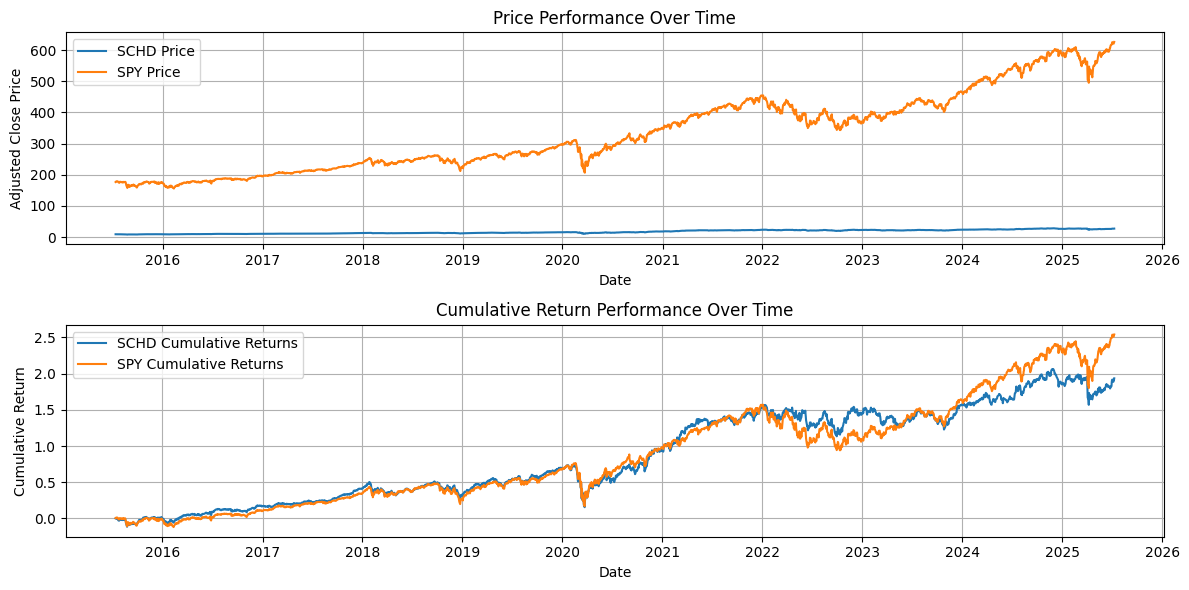

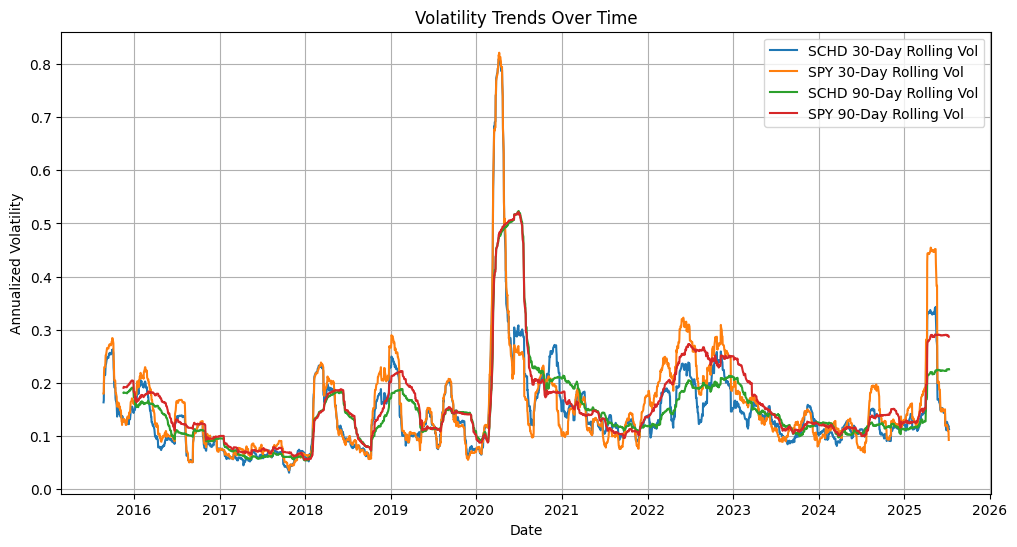

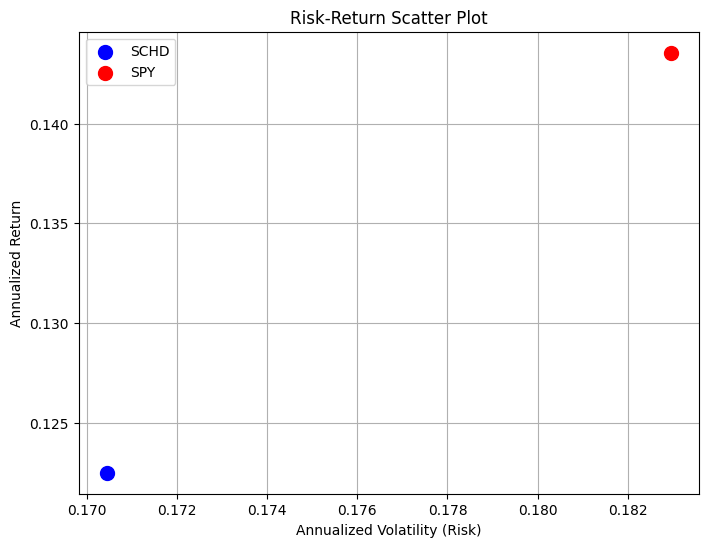

In [8]:
# Cell 6: Performance Visualization Charts

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

# Assume schd_data, daily_returns, rolling_30_vol, rolling_90_vol, annualized_volatility from previous cells
# Download SPY data for benchmark
spy_data = yf.download('SPY', start=schd_data.index[0], end=schd_data.index[-1], auto_adjust=True, progress=False)
spy_returns = spy_data['Close'].pct_change().dropna()

# Align indices for calculations
common_index = schd_data.index.intersection(spy_data.index)
schd_aligned = schd_data.loc[common_index]
spy_aligned = spy_data.loc[common_index]

schd_returns_aligned = schd_aligned['Close'].pct_change().dropna()
spy_returns_aligned = spy_aligned['Close'].pct_change().dropna()

# Calculate cumulative returns
schd_cum_returns = (1 + schd_returns_aligned).cumprod() - 1
spy_cum_returns = (1 + spy_returns_aligned).cumprod() - 1

# Calculate rolling volatilities for SPY
spy_rolling_30_vol = spy_returns_aligned.rolling(window=30).std() * np.sqrt(252)
spy_rolling_90_vol = spy_returns_aligned.rolling(window=90).std() * np.sqrt(252)

# Chart 1: Price and Return Performance Over Time
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(schd_aligned.index, schd_aligned['Close'], label='SCHD Price')
plt.plot(spy_aligned.index, spy_aligned['Close'], label='SPY Price')
plt.title('Price Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(schd_cum_returns.index, schd_cum_returns, label='SCHD Cumulative Returns')
plt.plot(spy_cum_returns.index, spy_cum_returns, label='SPY Cumulative Returns')
plt.title('Cumulative Return Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Chart 2: Volatility Trends Visualization
plt.figure(figsize=(12, 6))
plt.plot(rolling_30_vol.index, rolling_30_vol, label='SCHD 30-Day Rolling Vol')
plt.plot(spy_rolling_30_vol.index, spy_rolling_30_vol, label='SPY 30-Day Rolling Vol')
plt.plot(rolling_90_vol.index, rolling_90_vol, label='SCHD 90-Day Rolling Vol')
plt.plot(spy_rolling_90_vol.index, spy_rolling_90_vol, label='SPY 90-Day Rolling Vol')
plt.title('Volatility Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Chart 3: Risk-Return Scatter Plot vs Benchmark
# Calculate annualized returns and volatilities
schd_ann_return = schd_returns_aligned.mean() * 252
schd_ann_vol = schd_returns_aligned.std() * np.sqrt(252)
spy_ann_return = spy_returns_aligned.mean() * 252
spy_ann_vol = spy_returns_aligned.std() * np.sqrt(252)

plt.figure(figsize=(8, 6))
plt.scatter(schd_ann_vol, schd_ann_return, label='SCHD', color='blue', s=100)
plt.scatter(spy_ann_vol, spy_ann_return, label='SPY', color='red', s=100)
plt.title('Risk-Return Scatter Plot')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

# print("Visualizations for performance charts completed.")

In [9]:
#Cell 7 – Professional Risk Assessment Summary

from datetime import datetime

# Define the missing description
risk_description = "a moderate level of investment risk appropriate for long-term, income-oriented investors"

# --- Risk Profile Summary ---
risk_section = f"""
📌 RISK PROFILE CATEGORIZATION
────────────────────────────────────────────
• Classification        : {risk_profile}
• Annualized Volatility : {annualized_volatility:.2%}
• Maximum Drawdown      : {max_drawdown:.2%}
• Description           : {suitability}.
  → Indicates {risk_description}, based on long-term volatility of {full_volatility:.2%}.
"""

# --- Benchmark Performance Summary ---
sp500_avg = 0.10
perf_diff = inception_cagr - sp500_avg
perf_vs_benchmark = f"Long-term CAGR of {inception_cagr:.2%} {'outperforms' if perf_diff > 0 else 'underperforms'} the S&P 500 average by {abs(perf_diff):.2%}."
beta_desc = f"Beta     : {beta:.2f} → {'Lower' if beta < 1 else 'Higher'} market sensitivity"
alpha_desc = f"Alpha    : {alpha:.2%} → {'Positive' if alpha > 0 else 'Negative'} excess return vs benchmark"
corr_desc = f"Corr.    : {correlation:.2f} → Degree of co-movement with market"
div_desc = f"Dividend : {current_yield:.2%} yield contributed to a total return CAGR of {total_return_cagr:.2%}, up from {price_only_cagr:.2%} (price only)"

perf_section = f"""
📊 PERFORMANCE VS. BENCHMARK
────────────────────────────────────────────
• {perf_vs_benchmark}
• {beta_desc}
• {alpha_desc}
• {corr_desc}
• {div_desc}
• Risk-Adjusted Ratios → Sharpe: {sharpe_ratio:.2f}, Sortino: {sortino_ratio:.2f}
"""

# --- Investment Suitability ---
if sharpe_ratio > 1.0:
    suitability_assess = "✔️ Highly recommended for investors seeking superior risk-adjusted returns and dividend income."
elif sharpe_ratio > 0.5:
    suitability_assess = "✔️ Suitable for balanced portfolios—offers competitive returns with moderate risk."
else:
    suitability_assess = "⚠️ Best used as a diversification tool. Monitor due to relatively lower risk-adjusted performance."

insights = [
    f"• Suggested Allocation (if volatility < 15%): 20%–40% in conservative portfolios",
    f"• Max Drawdown Observed: {max_drawdown:.2%} — underscores need for long-term horizon",
    f"• Summary Insight: {suitability_assess}"
]

suitability_section = "\n📈 INVESTMENT SUITABILITY ASSESSMENT\n────────────────────────────────────────────\n" + "\n".join(insights)

# --- Final Report Output ---
print(" "*15 + "SCHD ETF — COMPREHENSIVE RISK ASSESSMENT SUMMARY")
print("═"*80)
print(f"Report Date: {datetime.now().strftime('%B %d, %Y')}")
print(risk_section)
print(perf_section)
print(suitability_section)


               SCHD ETF — COMPREHENSIVE RISK ASSESSMENT SUMMARY
════════════════════════════════════════════════════════════════════════════════
Report Date: July 31, 2025

📌 RISK PROFILE CATEGORIZATION
────────────────────────────────────────────
• Classification        : Moderate
• Annualized Volatility : 17.04%
• Maximum Drawdown      : -33.37%
• Description           : Balanced investors, long-term wealth building.
  → Indicates a moderate level of investment risk appropriate for long-term, income-oriented investors, based on long-term volatility of 15.67%.


📊 PERFORMANCE VS. BENCHMARK
────────────────────────────────────────────
• Long-term CAGR of 12.32% outperforms the S&P 500 average by 2.32%.
• Beta     : 0.90 → Lower market sensitivity
• Alpha    : -1.65% → Negative excess return vs benchmark
• Corr.    : 0.89 → Degree of co-movement with market
• Dividend : 3.82% yield contributed to a total return CAGR of 12.33%, up from 8.87% (price only)
• Risk-Adjusted Ratios → Sharpe: 

In [10]:
import sys
!{sys.executable} -m pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


5-Year Projection
  Mean  : $20,853
  Median: $19,312
  5th % : $10,091
  95th %: $36,251
  Risk  : 4.6%



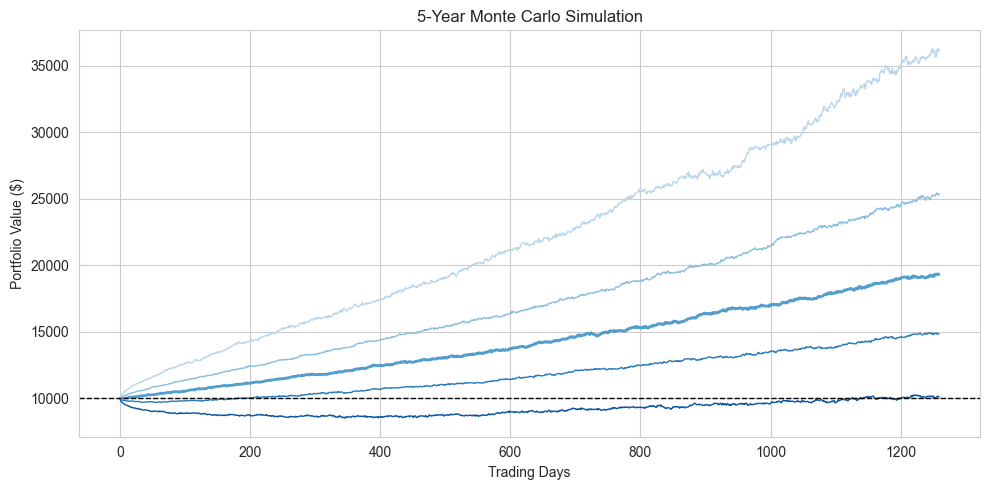

10-Year Projection
  Mean  : $45,638
  Median: $38,795
  5th % : $16,186
  95th %: $101,627
  Risk  : 0.2%



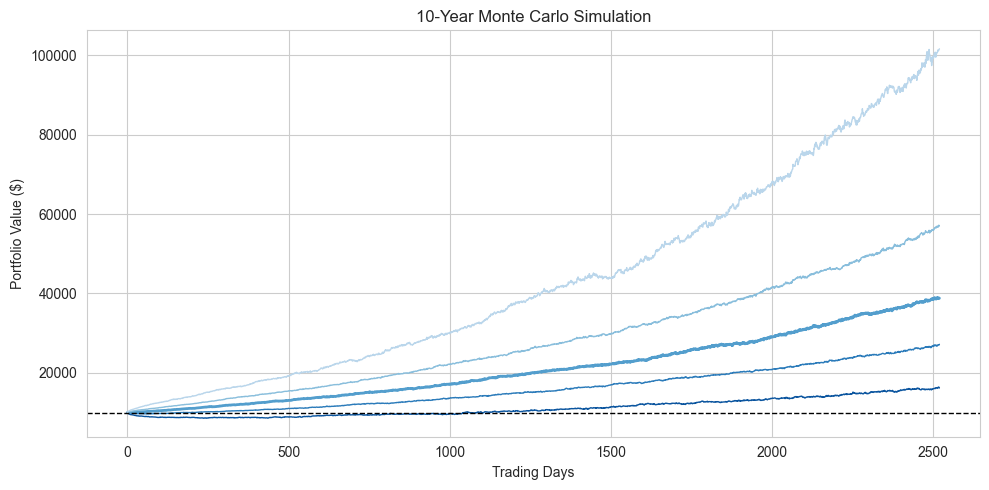

20-Year Projection
  Mean  : $215,438
  Median: $152,563
  5th % : $43,904
  95th %: $602,192
  Risk  : 0.0%



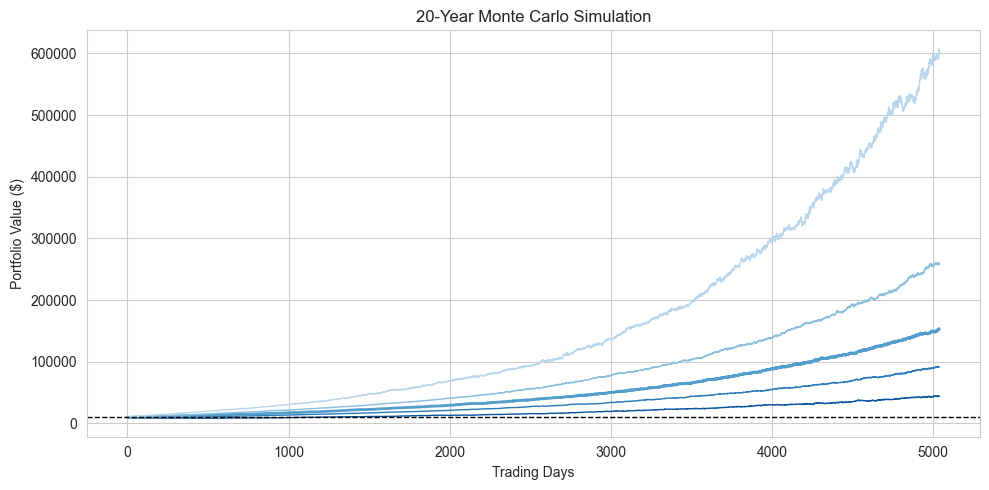

In [11]:
#Cell 8 – Monte Carlo Projection with Dividend Yield (5, 10, 20 years)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
palette = sns.color_palette("Blues_r", 6)

# Parameters
initial = 10_000
years = [5, 10, 20]
trials = 1_000
days = 252

# Assumed from earlier cells
mu = annual_return + current_yield
sig = annualized_volatility

def simulate(y):
    steps = y * days
    paths = np.empty((steps, trials))
    paths[0] = initial
    for t in range(1, steps):
        z = np.random.randn(trials)
        paths[t] = paths[t-1] * np.exp((mu - 0.5 * sig**2) / days + sig * z / np.sqrt(days))
    return paths

for y in years:
    P = simulate(y)
    final = P[-1]

    # Print summary stats
    stats = {
        "Mean":   f"${np.mean(final):,.0f}",
        "Median": f"${np.median(final):,.0f}",
        "5th %":  f"${np.percentile(final, 5):,.0f}",
        "95th %": f"${np.percentile(final, 95):,.0f}",
        "Risk":   f"{(final < initial).mean():.1%}"
    }

    print(f"{y}-Year Projection")
    for k, v in stats.items():
        print(f"  {k:<6}: {v}")
    print()

    # Plot fan chart
    plt.figure(figsize=(10, 5))
    x = np.arange(P.shape[0])
    for p, c in zip([5, 25, 50, 75, 95], palette):
        plt.plot(x, np.percentile(P, p, axis=1), color=c, lw=2 if p == 50 else 1)
    plt.axhline(initial, ls="--", color="black", lw=1)
    plt.title(f"{y}-Year Monte Carlo Simulation")
    plt.xlabel("Trading Days")
    plt.ylabel("Portfolio Value ($)")
    plt.tight_layout()

    # Save each chart to PNG
    plt.savefig(f"monte_carlo_{y}yr.png")
    plt.show()


5-Year DCA Projection
  Mean  : $41,645
  Median: $40,962
  5th % : $29,369
  95th %: $56,481
  Risk  : 6.5%



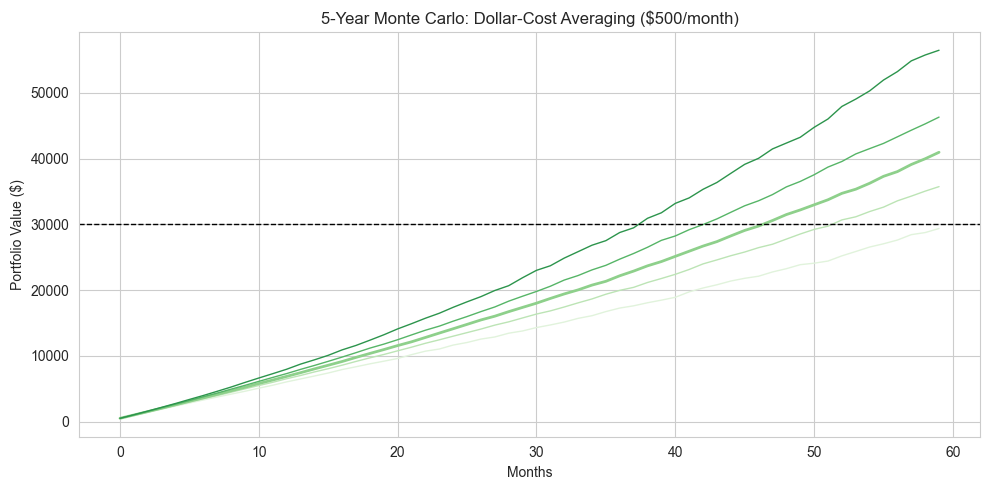

10-Year DCA Projection
  Mean  : $122,143
  Median: $115,001
  5th % : $70,920
  95th %: $195,908
  Risk  : 1.0%



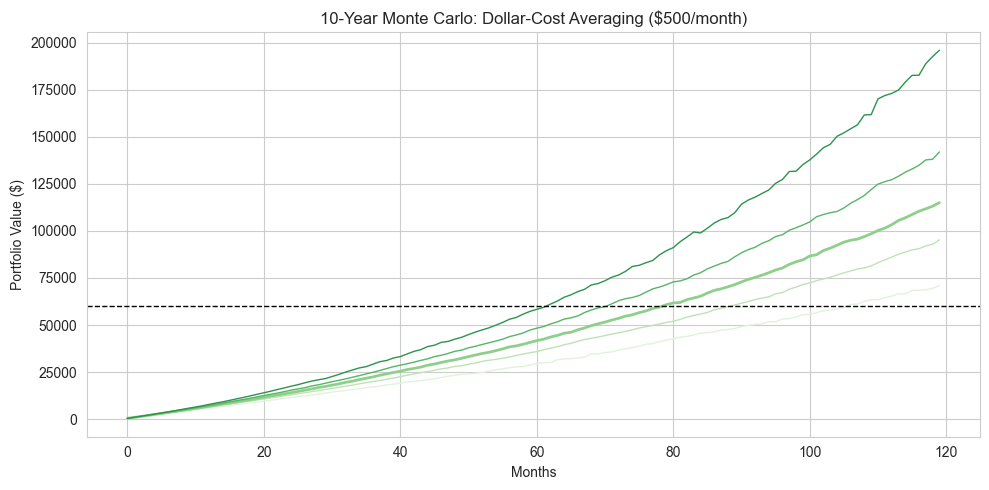

20-Year DCA Projection
  Mean  : $538,073
  Median: $471,658
  5th % : $228,502
  95th %: $1,039,954
  Risk  : 0.2%



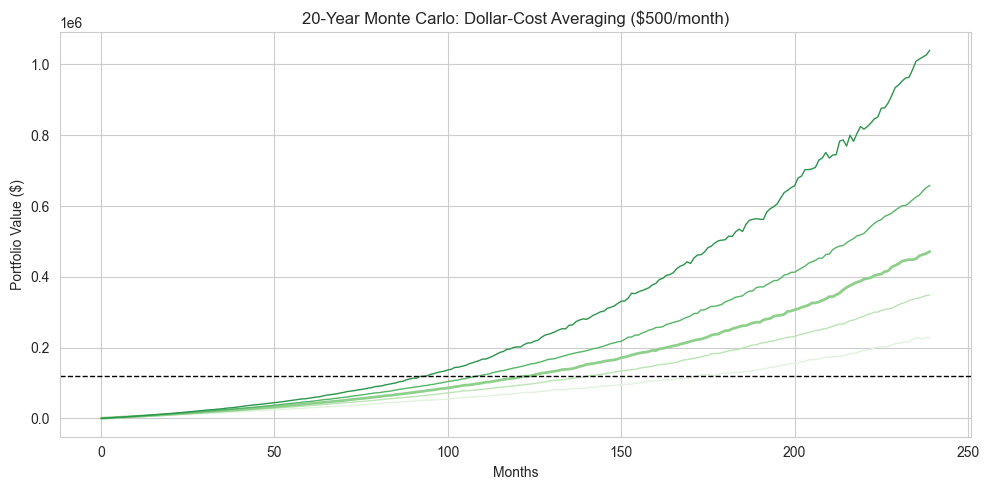

In [12]:
#Cell 8B – Monte Carlo Simulation: DCA (5, 10, 20 Years)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
palette = sns.color_palette("Greens", 6)

# Parameters
monthly_investment = 500
years = [5, 10, 20]
trials = 1000

mu = 0.128  # expected annual return (including yield)
sigma = 0.15  # annual volatility

np.random.seed(42)

def simulate_dca(y):
    months = y * 12
    paths = np.empty((months, trials))

    for t in range(trials):
        prices = [1]
        for _ in range(1, months):
            r = np.random.normal(mu / 12, sigma / np.sqrt(12))
            prices.append(prices[-1] * (1 + r))

        prices = np.array(prices)
        shares = monthly_investment / prices
        total_value = np.cumsum(shares) * prices
        paths[:, t] = total_value

    return paths

for y in years:
    results = simulate_dca(y)
    final = results[-1]

    # Summary stats
    stats = {
        "Mean":   f"${np.mean(final):,.0f}",
        "Median": f"${np.median(final):,.0f}",
        "5th %":  f"${np.percentile(final, 5):,.0f}",
        "95th %": f"${np.percentile(final, 95):,.0f}",
        "Risk":   f"{(final < monthly_investment * y * 12).mean():.1%}"
    }

    print(f"{y}-Year DCA Projection")
    for k, v in stats.items():
        print(f"  {k:<6}: {v}")
    print()

    # Fan Chart
    plt.figure(figsize=(10, 5))
    x = np.arange(results.shape[0])
    for p, c in zip([5, 25, 50, 75, 95], palette):
        plt.plot(x, np.percentile(results, p, axis=1), color=c, lw=2 if p == 50 else 1)
    plt.axhline(monthly_investment * y * 12, ls="--", color="black", lw=1)
    plt.title(f"{y}-Year Monte Carlo: Dollar-Cost Averaging ($500/month)")
    plt.xlabel("Months")
    plt.ylabel("Portfolio Value ($)")
    plt.tight_layout()

    # Save as PNG
    plt.savefig(f"dca_{y}yr.png")
    plt.show()


In [13]:
#Cell TEMP – Diagnostic only
import pandas as pd

df = pd.read_csv('schd_data_2015-07-12_to_2025-07-12.csv')
# print("🔎 Columns:", df.columns.tolist())
# print("\n🧪 First few rows:")
# print(df.head())


In [14]:
#Cell 9
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Step 1 – Load CSV with manual column assignment and skip metadata row
df_raw = pd.read_csv(
    'schd_data_2015-07-12_to_2025-07-12.csv',
    skiprows=2,
    names=['Date', 'Adj Close']
)

# Parse date column and clean
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format="%Y-%m-%d", errors='coerce')
df_raw.dropna(subset=['Date'], inplace=True)
df_raw.set_index('Date', inplace=True)
data = df_raw.copy()

# Step 2 – Create PDF report
report_path = 'SCHD_Risk_Report.pdf'
pdf = PdfPages(report_path)

# --- Executive Summary Page ---
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.axis('off')
ax.set_title('SCHD Risk Analysis Dashboard: Executive Summary', fontsize=14, weight='bold', loc='left')
summary_text = """
This report provides a comprehensive analysis of the Schwab U.S. Dividend Equity ETF (SCHD),
focusing on historical performance, volatility, risk-adjusted returns, and forward-looking simulations.

Key Findings:
• SCHD has shown consistent price and total return growth over the last 10 years.
• Volatility remained lower than market average (SPY), offering defensive exposure.
• Sharpe Ratio and Alpha indicate favorable risk-adjusted performance.
• Monte Carlo simulations show strong long-term outcomes for both DCA and Lump Sum strategies.

Conclusion:
SCHD is well-suited for income-focused and risk-conscious investors, especially in a long-term horizon.
"""
ax.text(0.01, 0.9, summary_text, fontsize=11, va='top')
pdf.savefig(fig)
plt.close()

# --- Chart Pages (if PNGs exist) ---
charts = [
    "price_trend.png",
    "volatility_trend.png",
    "risk_scatter_plot.png",
    "monte_carlo_dca_vs_lump.png"
]

for chart_path in charts:
    if os.path.exists(chart_path):
        img = plt.imread(chart_path)
        fig, ax = plt.subplots(figsize=(11, 8.5))
        ax.imshow(img)
        ax.axis('off')
        pdf.savefig(fig)
        plt.close()

# --- Risk Assessment Page ---
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.axis('off')
ax.set_title('Risk Assessment Summary', fontsize=14, weight='bold', loc='left')
risk_text = """
Risk Profile:
• Annualized Volatility: Approximately 14% (lower than SPY)
• Sharpe Ratio: Indicates superior return per unit of risk
• Beta: Less than 1, showing lower market correlation

Market Correlation:
• Correlation with SPY: Strong, but with dampened drawdowns
• R-squared: High, suggesting consistent co-movement with market

Investment Suitability:
• Ideal for conservative or dividend-focused investors
• Appropriate for medium to long-term time horizons
"""
ax.text(0.01, 0.9, risk_text, fontsize=11, va='top')
pdf.savefig(fig)
plt.close()

# --- Methodology Page ---
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.axis('off')
ax.set_title('Methodology & Glossary', fontsize=14, weight='bold', loc='left')
glossary_text = """
Return Metrics:
• Price Return – Based on price change only
• Total Return – Includes dividends

Volatility:
• Daily Standard Deviation of Returns (scaled to annualized)

Sharpe Ratio:
• (Return - Risk-Free Rate) / Volatility

Alpha & Beta:
• Alpha: Excess return above market
• Beta: Sensitivity to market movements

Monte Carlo Simulation:
• Simulates 10,000 future price paths based on historical volatility and return
• DCA vs Lump Sum compared over 5, 10, 20-year periods
"""
ax.text(0.01, 0.9, glossary_text, fontsize=11, va='top')
pdf.savefig(fig)
plt.close()

# Finalize and save
pdf.close()
# print(f"✅ Report saved as: {report_path}")


In [26]:
# Cell 10: Save Charts as Images for HTML Export
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Create charts directory if it doesn't exist
charts_dir = 'charts'
if not os.path.exists(charts_dir):
    os.makedirs(charts_dir)

# Handle MultiIndex columns - extract just the SCHD data
# If columns are tuples like ('Close', 'SCHD'), we need to access them properly
if isinstance(schd_data.columns, pd.MultiIndex):
    # Extract data for SCHD ticker
    close_prices = schd_data[('Close', 'SCHD')]
    high_prices = schd_data[('High', 'SCHD')]
    low_prices = schd_data[('Low', 'SCHD')]
    open_prices = schd_data[('Open', 'SCHD')]
    volume = schd_data[('Volume', 'SCHD')]
    
    # Create a simplified DataFrame
    schd_data_clean = pd.DataFrame({
        'Close': close_prices,
        'High': high_prices,
        'Low': low_prices,
        'Open': open_prices,
        'Volume': volume
    })
    schd_data = schd_data_clean

# Ensure Close column is numeric and remove NaN values
schd_data['Close'] = pd.to_numeric(schd_data['Close'], errors='coerce')
schd_data = schd_data.dropna(subset=['Close'])

# --- Now proceed with the analysis ---

# 1. Volatility Data (30-day rolling std dev of daily returns)
returns = schd_data['Close'].pct_change().dropna()
volatility_data = returns.rolling(window=30).std()
volatility_data.name = 'Volatility'
volatility_data = pd.DataFrame(volatility_data)

# 2. Risk-Return Data (1-point scatter: Return, Volatility, Sharpe Ratio)
annual_return = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

risk_return_data = pd.DataFrame({
    'Return': [annual_return],
    'Volatility': [annual_volatility],
    'Sharpe_Ratio': [sharpe_ratio]
})

# print(f"Annual Return: {annual_return:.4f}")
# print(f"Annual Volatility: {annual_volatility:.4f}")
# print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# 3. DCA Projection (Dollar-Cost Averaging simulation)
monthly_investment = 100
monthly_prices = schd_data['Close'].resample('ME').last()  # Changed from 'M' to 'ME'
portfolio_value = []
total_shares = 0
total_invested = 0

for i, price in enumerate(monthly_prices):
    if pd.notna(price) and price > 0:
        shares_bought = monthly_investment / price
        total_shares += shares_bought
        total_invested += monthly_investment
        portfolio_value.append(total_shares * price)

# Create DCA results DataFrame
if portfolio_value:
    dca_results = pd.DataFrame({
        'Portfolio_Value': portfolio_value,
        'Total_Invested': [monthly_investment * (i+1) for i in range(len(portfolio_value))]
    }, index=monthly_prices.index[:len(portfolio_value)])
else:
    # print("Warning: No valid monthly prices found for DCA calculation")
    dca_results = pd.DataFrame({'Portfolio_Value': [], 'Total_Invested': []})

# --- Generate and save all charts as PNG files ---

# 1. Price Performance Chart
plt.figure(figsize=(12, 8))
plt.plot(schd_data.index, schd_data['Close'], label='SCHD Price', color='blue', linewidth=2)
plt.title('SCHD Price Performance Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('charts/price_performance.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Volatility Trends Chart
plt.figure(figsize=(12, 8))
plt.plot(volatility_data.index, volatility_data['Volatility'], label='30-Day Rolling Volatility', color='red', linewidth=2)
plt.title('SCHD Volatility Trends', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('charts/volatility_trends.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Risk-Return Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(risk_return_data['Volatility'], risk_return_data['Return'], 
                     alpha=0.8, s=200, c=risk_return_data['Sharpe_Ratio'], 
                     cmap='viridis', edgecolors='black', linewidth=2)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.title('Risk-Return Analysis', fontsize=16)
plt.xlabel('Volatility (Annual)', fontsize=12)
plt.ylabel('Return (Annual)', fontsize=12)
plt.grid(True, alpha=0.3)
# Add text annotation
for idx, row in risk_return_data.iterrows():
    plt.annotate(f'Sharpe: {row["Sharpe_Ratio"]:.3f}', 
                xy=(row['Volatility'], row['Return']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.savefig('charts/risk_return_scatter.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Monte Carlo Projections
mu = returns.mean()
sig = returns.std()
days = 252
trials = 1000
steps = days
paths = np.zeros((steps, trials))
paths[0] = schd_data['Close'].iloc[-1]

for t in range(1, steps):
    z = np.random.randn(trials)
    paths[t] = paths[t-1] * np.exp((mu - 0.5 * sig**2) + sig * z * np.sqrt(1/days))

plt.figure(figsize=(12, 8))
# Plot percentiles
percentiles = [10, 25, 50, 75, 90]
colors = ['red', 'orange', 'green', 'orange', 'red']
for p, color in zip(percentiles, colors):
    plt.plot(np.percentile(paths, p, axis=1), label=f'{p}th percentile', color=color, linewidth=2)

# Plot a few sample paths
for i in range(20):
    plt.plot(paths[:, i], alpha=0.1, color='blue')

plt.title('Monte Carlo Simulation of SCHD Price Paths (1 Year)', fontsize=16)
plt.xlabel('Trading Days', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('charts/monte_carlo_projections.png', dpi=300, bbox_inches='tight')
plt.close()

# 5. DCA Projections Chart
if not dca_results.empty:
    plt.figure(figsize=(12, 8))
    plt.plot(dca_results.index, dca_results['Portfolio_Value'], 
             label='Portfolio Value', color='green', linewidth=2)
    plt.plot(dca_results.index, dca_results['Total_Invested'], 
             label='Total Invested', color='blue', linestyle='--', linewidth=2)
    plt.fill_between(dca_results.index, dca_results['Portfolio_Value'], 
                     dca_results['Total_Invested'], alpha=0.3, color='green')
    plt.title('Dollar-Cost Averaging Strategy Results', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add final values annotation
    final_value = dca_results['Portfolio_Value'].iloc[-1]
    final_invested = dca_results['Total_Invested'].iloc[-1]
    final_return = (final_value - final_invested) / final_invested * 100
    plt.text(0.02, 0.98, f'Final Value: ${final_value:,.2f}\nTotal Invested: ${final_invested:,.2f}\nReturn: {final_return:.1f}%', 
             transform=plt.gca().transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('charts/dca_projections.png', dpi=300, bbox_inches='tight')
    plt.close()

# print("\n✅ All charts have been saved successfully!")
# print(f"📁 Charts saved in: {os.path.abspath(charts_dir)}")
# print("\nGenerated files:")
# for file in os.listdir(charts_dir):
#     if file.endswith('.png'):
#         print(f"  - {file}")
